# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Neighborhood Case Studies:
### 1) New Dorp - Midland Beach, Staten Island
### 2) Hammels, Arverne, and Edgemere, Queens
Author: Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib,matplotlib,seaborn,contextily

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
geopandas : 0.11.1
matplotlib: 3.5.2
seaborn   : 0.11.2
contextily: 1.2.0



# Read In Data

In [3]:
# list items in data folder
%ls data/

README.md                       street-flooding-query.csv
street-flooding-complaints.csv  streets-clipped.gpkg


## Street Flooding Complaints

In [4]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# preview data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,02 STATEN ISLAND,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':..."
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,03 STATEN ISLAND,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':..."
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,02 STATEN ISLAND,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'..."
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,05 QUEENS,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':..."
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,06 QUEENS,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'..."


In [5]:
# printing the column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24815 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   incident_zip                    24817 non-null  float64
 8   incident_address                16002 non-null  object 
 9   street_name                     16002 non-null  object 
 10  cross_street_1                  21821 non-null  object 
 11  cross_street_2                  21816 non-null  object 
 12  address_type                    

## Neighborhood Tabulation Areas (NTAs)

In [6]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_gdf = gpd.read_file(url)
nta_gdf = nta_gdf.to_crs(epsg=2263)

# full name
nta_gdf['ntaname_full'] = nta_gdf['ntaname'] + ', ' + nta_gdf['boro_name']

# previewing first five rows in data
print('shape of data: {}'.format(nta_gdf.shape[0]))
nta_gdf.head()

shape of data: 195


,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_full
0,QN08,77412747.847,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens"
1,BX28,25666124.5948,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548...","Van Cortlandt Village, Bronx"
2,QN55,82461393.7368,081,South Ozone Park,36708.1693055,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819...","South Ozone Park, Queens"
3,BK50,82089678.6389,047,Canarsie,43703.6096661,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523...","Canarsie, Brooklyn"
4,BX41,14716710.7402,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284...","Mount Hope, Bronx"


<AxesSubplot:>

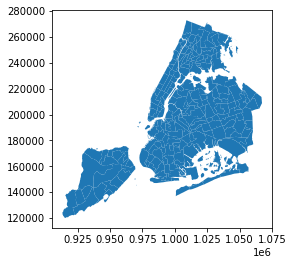

In [7]:
# sanity check
nta_gdf.plot()

## Streets

In [8]:
path = 'data/streets-clipped.gpkg'
streets = gpd.read_file(path)

print('shape of data: {}'.format(streets.shape))
print('street id is unique: {}'.format(streets['physicalid'].is_unique))
print(streets.crs)

streets.head()

shape of data: (99124, 12)
street id is unique: True
epsg:2263


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99..."
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80..."
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26..."
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84..."
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69..."


In [9]:
# summarize columns
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99124 entries, 0 to 99123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [10]:
# sanity check, examine counts of geom types
streets.geom_type.value_counts()

LineString    99124
dtype: int64

<AxesSubplot:>

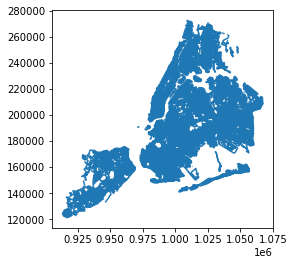

In [11]:
# sanity check plot
streets.plot()

# Make GeoDataframe and Spatial Join NTA Information to Complaints

In [12]:
crs=2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe form x,y points
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# spatial join with nta information
gdf = gpd.sjoin(
    gdf, 
    nta_gdf, 
    how="inner", 
    predicate='within'
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (24814, 37)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,ntaname_full
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,POINT (951437.000 148868.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,POINT (954138.000 151251.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"


# Case Study Selection: Neighborhoods with the Most Street Flooding Complaints

In [13]:
(gdf
 .groupby(by='ntaname_full')['unique_key']
 .count()
 .rename('count')
 .reset_index()
 .sort_values('count', ascending=False)
 .head(10)
)

,ntaname_full,count
116,"New Dorp-Midland Beach, Staten Island",690
80,"Hammels-Arverne-Edgemere, Queens",662
97,"Lindenwood-Howard Beach, Queens",566
157,"St. Albans, Queens",550
61,"Far Rockaway-Bayswater, Queens",520
17,"Borough Park, Brooklyn",501
127,"Old Town-Dongan Hills-South Beach, Staten Island",500
76,"Great Kills, Staten Island",484
143,"Rosedale, Queens",439
123,"Oakwood-Oakwood Beach, Staten Island",396


Let's select the top two neighborhoods to examine as case studies.

# Case Studies

## 1) New Dorp - Midland Beach, Staten Island
## 2) Hammels, Arverne, and Edgemere, Queens

## Case Study: New Dorp - Midland Beach, Staten Island

In [14]:
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

# make geodataframe from x,y points
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# spatial join with nta information
gdf = gpd.sjoin(
    gdf, 
    nta_gdf, 
    how="inner", 
    predicate='within'
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (24814, 37)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,ntaname_full
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,POINT (951437.000 148868.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,POINT (954138.000 151251.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"New Dorp-Midland Beach, Staten Island"


In [15]:
# locate midland beach nta shape
name = 'New Dorp-Midland Beach, Staten Island'
midland_beach_shape = (
    nta_gdf
    .loc[nta_gdf['ntaname_full'] == name]
    .reset_index(drop=True)
)

# preview data
midland_beach_shape.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_full
0,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5,"MULTIPOLYGON (((960721.678 147492.705, 960370....","New Dorp-Midland Beach, Staten Island"


<AxesSubplot:>

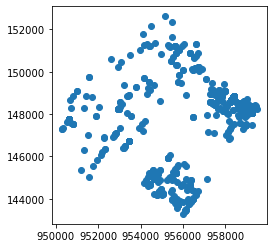

In [16]:
# clipping complaints that fall within Midland Beach
midland_beach_gdf = gpd.clip(gdf, midland_beach_shape)

# sanity check plot
midland_beach_gdf.plot()

shape of data: (764, 12)


<AxesSubplot:>

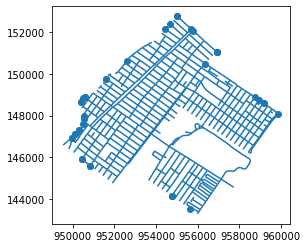

In [17]:
# clip streets within Midland Beach
streets_clipped = gpd.clip(streets, midland_beach_shape)

# recalculate street length
streets_clipped['shape_leng'] = streets_clipped['geometry'].length

# sanity check plot
print('shape of data: {}'.format(streets_clipped.shape))
streets_clipped.plot()

In [18]:
# examine geom_type values
streets_clipped.geom_type.value_counts()

LineString            725
Point                  33
GeometryCollection      5
MultiLineString         1
dtype: int64

In [19]:
# retrieve only linestring geom types
streets_clipped = (
    streets_clipped.loc[streets_clipped.geom_type == 'LineString']
    .reset_index(drop=True)
)

# sanity check geom types
streets_clipped.geom_type.value_counts()

LineString    725
dtype: int64

## Snap Points to Lines

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [20]:
# offset 80 ft.
offset = 80
bbox = midland_beach_gdf.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

3036         [38, 42, 14]
16044             [90, 3]
20169    [37, 40, 45, 46]
19916    [38, 42, 47, 14]
20870    [38, 42, 47, 14]
dtype: object

In [21]:
tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

# join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True),
    on="line_i"
)

# join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    midland_beach_gdf['geometry'].rename("point"),
    on="pt_idx"
)

# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp,
    geometry="geometry",
    crs=midland_beach_gdf.crs
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,3036,38.0,64016,HAMDEN AVE,HAMDEN,HAMDEN AVE,1,Street,30.0,13,13,5,820.431026,"LINESTRING (954892.740 151197.107, 955566.063 ...",POINT (955376.000 151174.000)
1,3036,42.0,49923,HUNTER AVE,HUNTER,HUNTER AVE,1,Street,30.0,13,13,5,264.288266,"LINESTRING (955284.172 151241.150, 955501.744 ...",POINT (955376.000 151174.000)
2,3036,14.0,102947,BOWDEN ST,BOWDEN,BOWDEN ST,1,Street,30.0,13,13,5,425.281423,"LINESTRING (955569.279 151556.710, 955284.172 ...",POINT (955376.000 151174.000)
3,16044,90.0,98862,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,458.595100,"LINESTRING (954222.466 151355.690, 954597.899 ...",POINT (954436.000 151202.000)
4,16044,3.0,102931,HAMDEN AVE,HAMDEN,HAMDEN AVE,1,Street,30.0,13,13,5,590.710057,"LINESTRING (954296.799 151609.830, 954781.221 ...",POINT (954436.000 151202.000)


In [22]:
# calculate distance from line to point
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# discard any lines that are greater than tolerance from points
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
2161,16933,687.0,173628,CEDAR GROVE AVE,CEDAR GROVE,CEDAR GROVE AVE,1,Street,30.0,13,13,5,81.013544,"LINESTRING (956774.728 144439.828, 956728.977 ...",POINT (956729.000 144373.000),0.001732
1317,21386,366.0,53940,FREEBORN ST,FREEBORN,FREEBORN ST,1,Street,30.0,13,13,5,379.453064,"LINESTRING (958104.215 147999.309, 957884.712 ...",POINT (958104.000 147999.000),0.003294
148,2101,343.0,84599,ROSE AVE,ROSE,ROSE AVE,1,Street,30.0,13,13,5,249.365873,"LINESTRING (951137.861 148456.727, 951338.494 ...",POINT (951338.000 148309.000),0.003960
402,4106,241.0,52066,KISWICK ST,KISWICK,KISWICK ST,1,Street,32.0,13,13,5,509.998826,"LINESTRING (957795.024 148848.019, 957495.893 ...",POINT (957795.000 148848.000),0.008792
406,12725,241.0,52066,KISWICK ST,KISWICK,KISWICK ST,1,Street,32.0,13,13,5,509.998826,"LINESTRING (957795.024 148848.019, 957495.893 ...",POINT (957795.000 148848.000),0.008792


In [23]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273
9,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273
68,301.0,89719,3 ST,3,3 ST,1,Street,30.0,13,13,5,204.368178,"LINESTRING (951507.590 148960.030, 951387.141 ...",POINT (951437.000 148868.000),2.787056
79,91.0,98849,LISBON PL,LISBON,LISBON PL,1,Street,30.0,13,13,5,308.463539,"LINESTRING (954222.466 151355.690, 954034.853 ...",POINT (954138.000 151251.000),3.372281
80,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273


In [24]:
# position of nearest point from start of the line
pos = closest['geometry'].project(gpd.GeoSeries(closest['point']))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

# Create a new GeoDataFrame from the columns from the closest line and
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
9,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
68,301.0,89719,3 ST,3,3 ST,1,Street,30.0,13,13,5,204.368178,POINT (951439.252 148866.357),POINT (951437.000 148868.000),2.787056
79,91.0,98849,LISBON PL,LISBON,LISBON PL,1,Street,30.0,13,13,5,308.463539,POINT (954140.677 151248.949),POINT (954138.000 151251.000),3.372281
80,257.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273


In [25]:
# join back to the original points
updated_points = (
    midland_beach_gdf.drop(columns=['geometry', 'shape_leng'])
    .join(snapped)
    .dropna(subset=["geometry"])
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
3036,41651443,2019-02-08T10:08:00.000,2019-02-14T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,134 HUNTER AVENUE,HUNTER AVENUE,...,1,Street,30.0,13,13,5,264.288266,POINT (955377.788 151176.593),POINT (955376.000 151174.000),3.149889
16044,27342645,2014-02-05T12:02:00.000,2014-02-05T13:00:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,76 BEDFORD AVENUE,BEDFORD AVENUE,...,1,Street,30.0,13,13,5,458.595100,POINT (954437.832 151204.612),POINT (954436.000 151202.000),3.190815
20169,21912252,2011-11-17T18:04:00.000,2011-11-19T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,NaN,NaN,...,1,Street,30.0,13,13,5,360.979732,POINT (955956.929 151208.063),POINT (955957.000 151208.000),0.094420
19916,22596730,2012-01-26T12:46:00.000,2012-01-27T11:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,129 HUNTER AVENUE,HUNTER AVENUE,...,1,Street,30.0,13,13,5,264.288266,POINT (955332.032 151208.146),POINT (955334.000 151211.000),3.466604
20870,21078877,2011-08-20T10:47:00.000,2011-08-21T18:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,129 HUNTER AVENUE,HUNTER AVENUE,...,1,Street,30.0,13,13,5,264.288266,POINT (955332.032 151208.146),POINT (955334.000 151211.000),3.466604


<AxesSubplot:>

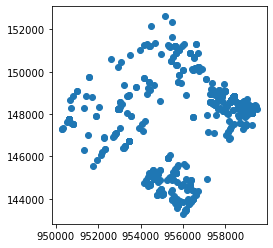

In [26]:
updated_points = gpd.GeoDataFrame(
    updated_points,
    geometry='point'
)

updated_points.plot()

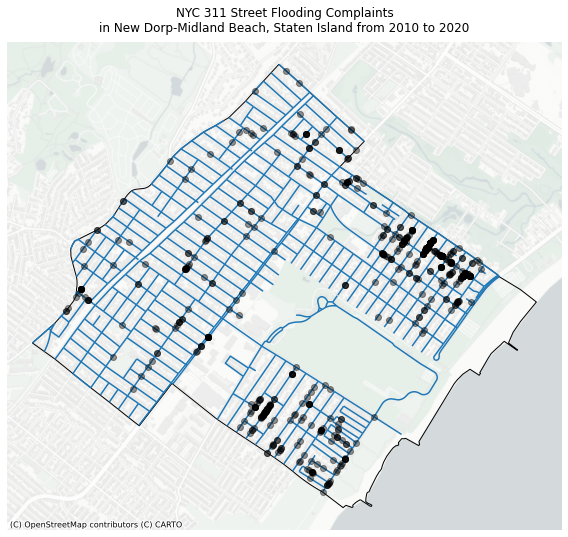

In [27]:
fig, ax = plt.subplots(figsize=(8, 8)) 

updated_points.plot(
    color='black', 
    edgecolor='black',
    alpha=.4,
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)

midland_beach_shape.plot(
    ax=ax, 
    zorder=1, 
    color='None', 
    edgecolor='black'
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

label = 'NYC 311 Street Flooding Complaints\n\
in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()

In [28]:
# buffer lines
streets_clipped = (
    streets_clipped
    .set_geometry('geometry')
    .assign(new_geom=lambda x: x.geometry.buffer(40, cap_style=2))
    .set_geometry('new_geom')
)

streets_clipped.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom
0,50152,RICHMOND RD,RICHMOND,RICHMOND RD,1,Street,42.0,13,13,5,312.580758,"LINESTRING (953615.529 151406.480, 953340.369 ...","POLYGON ((953359.347 151222.965, 953321.391 15..."
1,63907,N RAILROAD AVE,RAILROAD,N RAILROAD AVE,1,Street,30.0,13,13,5,266.606158,"LINESTRING (954973.756 151456.202, 954781.221 ...","POLYGON ((954808.890 151242.899, 954753.553 15..."
2,98860,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,78.668493,"LINESTRING (954158.195 151401.054, 954222.466 ...","POLYGON ((954245.532 151388.369, 954199.400 15..."
3,102931,HAMDEN AVE,HAMDEN,HAMDEN AVE,1,Street,30.0,13,13,5,590.710057,"LINESTRING (954296.799 151609.830, 954781.221 ...","POLYGON ((954804.112 151304.589, 954758.331 15..."
4,98861,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,311.130194,"LINESTRING (953904.291 151580.873, 954158.195 ...","POLYGON ((954181.313 151433.697, 954135.076 15..."


In [29]:
# group count of complaints by street
gdf_count = (
    updated_points
    .groupby(by='physicalid')['created_date']
    .count()
    .reset_index()
    .rename(columns={"created_date": "count"})
)
gdf_count.head()

,physicalid,count
0,100411,1
1,100451,1
2,100452,2
3,100822,8
4,100863,2


In [30]:
# joining count of complaints to streets
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

# examine df
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 725 entries, 0 to 724
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    725 non-null    object  
 1   st_label      725 non-null    object  
 2   st_name       725 non-null    object  
 3   full_stree    725 non-null    object  
 4   rw_type       725 non-null    object  
 5   rw_type_name  725 non-null    object  
 6   st_width      725 non-null    object  
 7   frm_lvl_co    725 non-null    object  
 8   to_lvl_co     725 non-null    object  
 9   borocode      725 non-null    object  
 10  shape_leng    725 non-null    float64 
 11  geometry      725 non-null    geometry
 12  new_geom      725 non-null    geometry
 13  count         725 non-null    int64   
dtypes: float64(1), geometry(2), int64(1), object(10)
memory usage: 85.0+ KB


In [31]:
# normalize counts
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft
0,50152,RICHMOND RD,RICHMOND,RICHMOND RD,1,Street,42.0,13,13,5,312.580758,"LINESTRING (953615.529 151406.480, 953340.369 ...","POLYGON ((953359.347 151222.965, 953321.391 15...",0,0.000000
1,63907,N RAILROAD AVE,RAILROAD,N RAILROAD AVE,1,Street,30.0,13,13,5,266.606158,"LINESTRING (954973.756 151456.202, 954781.221 ...","POLYGON ((954808.890 151242.899, 954753.553 15...",0,0.000000
2,98860,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,78.668493,"LINESTRING (954158.195 151401.054, 954222.466 ...","POLYGON ((954245.532 151388.369, 954199.400 15...",0,0.000000
3,102931,HAMDEN AVE,HAMDEN,HAMDEN AVE,1,Street,30.0,13,13,5,590.710057,"LINESTRING (954296.799 151609.830, 954781.221 ...","POLYGON ((954804.112 151304.589, 954758.331 15...",1,0.169288
4,98861,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,311.130194,"LINESTRING (953904.291 151580.873, 954158.195 ...","POLYGON ((954181.313 151433.697, 954135.076 15...",0,0.000000


In [32]:
# exammine distribution of counts
streets_with_count.loc[:, ['count', 'count_per_100ft']].describe()

,count,count_per_100ft
count,725.000000,725.000000
mean,0.944828,0.302664
std,4.041189,1.451175
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,59.000000,29.875949


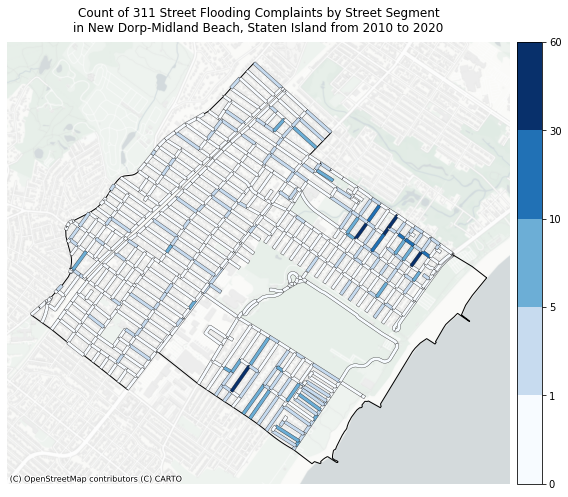

In [33]:
fig, ax = plt.subplots(figsize=(8, 8)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 5, 10, 30, 60], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax,
    zorder=2,                        
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(midland_beach_shape
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)


# setting title
label = 'Count of 311 Street Flooding Complaints by Street Segment\n\
in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

ax.axis('off')
plt.tight_layout()

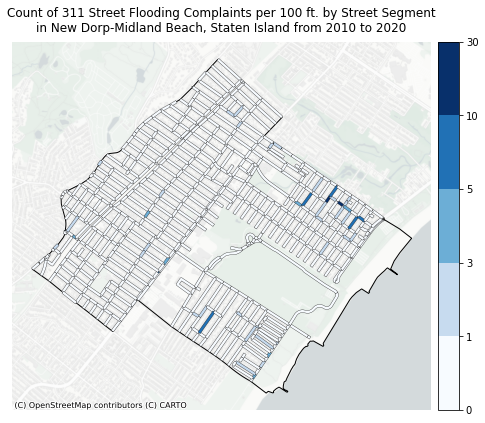

In [34]:
fig, ax = plt.subplots(figsize=(8, 8)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 3, 5, 10, 30], cmap.N)

streets_with_count.plot(
    column='count_per_100ft', 
    ax=ax,
    cax=cax,
    zorder=2,                        
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(midland_beach_shape
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)


# setting title
label = 'Count of 311 Street Flooding Complaints per 100 ft. by Street Segment\n\
in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

ax.axis('off')
plt.savefig('figures/midland-beach.png', dpi=250, bbox_inches='tight')

In [35]:
# create full street name
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft,street_and_id
0,50152,RICHMOND RD,RICHMOND,RICHMOND RD,1,Street,42.0,13,13,5,312.580758,"LINESTRING (953615.529 151406.480, 953340.369 ...","POLYGON ((953359.347 151222.965, 953321.391 15...",0,0.000000,"RICHMOND RD, id:50152"
1,63907,N RAILROAD AVE,RAILROAD,N RAILROAD AVE,1,Street,30.0,13,13,5,266.606158,"LINESTRING (954973.756 151456.202, 954781.221 ...","POLYGON ((954808.890 151242.899, 954753.553 15...",0,0.000000,"N RAILROAD AVE, id:63907"
2,98860,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,78.668493,"LINESTRING (954158.195 151401.054, 954222.466 ...","POLYGON ((954245.532 151388.369, 954199.400 15...",0,0.000000,"BEDFORD AVE, id:98860"
3,102931,HAMDEN AVE,HAMDEN,HAMDEN AVE,1,Street,30.0,13,13,5,590.710057,"LINESTRING (954296.799 151609.830, 954781.221 ...","POLYGON ((954804.112 151304.589, 954758.331 15...",1,0.169288,"HAMDEN AVE, id:102931"
4,98861,BEDFORD AVE,BEDFORD,BEDFORD AVE,1,Street,30.0,13,13,5,311.130194,"LINESTRING (953904.291 151580.873, 954158.195 ...","POLYGON ((954181.313 151433.697, 954135.076 15...",0,0.000000,"BEDFORD AVE, id:98861"


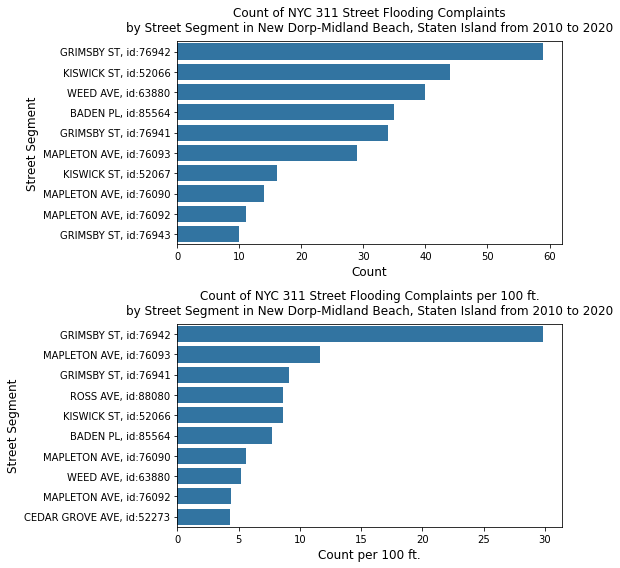

In [36]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 8))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints\n\
by Street Segment in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Street Segment', fontsize=12)

# second plot
data = streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in New Dorp-Midland Beach, Staten Island from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=12)
axs[1].set_ylabel('Street Segment', fontsize=12)

fig.tight_layout()

## Case Study: Hammels, Arverne, and Edgemere, Queens

In [37]:
# transform complaints to geodataframe
crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

# sanity check
gdf.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location,geometry
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000)
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':...",POINT (937878.000 143517.000)
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'...",POINT (960864.000 149333.000)
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':...",POINT (1015410.000 201741.000)
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'...",POINT (1027498.000 202160.000)


In [38]:
# streets
path = 'data/streets-clipped.gpkg'
streets = gpd.read_file(path)

streets.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99..."
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80..."
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26..."
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84..."
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69..."


In [39]:
# examine streets df
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99124 entries, 0 to 99123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [40]:
# return only Hammels-Arverne-Edgemere, Queens
name = 'Hammels-Arverne-Edgemere, Queens'
arverne_edgemere_shape = (
    nta_gdf
    .loc[nta_gdf['ntaname_full'] == name]
    .reset_index(drop=True)
)

arverne_edgemere_shape

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_full
0,QN12,61899914.5306,081,Hammels-Arverne-Edgemere,83078.8165976,Queens,4,"MULTIPOLYGON (((1048650.179 157173.329, 104869...","Hammels-Arverne-Edgemere, Queens"


<AxesSubplot:>

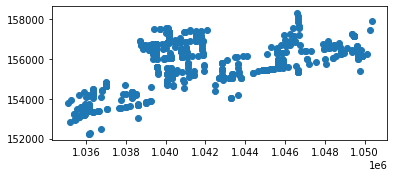

In [41]:
# clipping complaints that fall within arverne edgemere
arverne_edgemere_gdf = gpd.clip(
    gdf,
    arverne_edgemere_shape
)

arverne_edgemere_gdf.plot()

<AxesSubplot:>

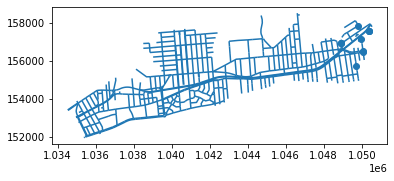

In [42]:
# clipping the points that only fall within the nta shapes
streets_clipped = gpd.clip(
    streets,
    arverne_edgemere_shape
)

# sanity check plot
streets_clipped.plot()

In [43]:
# sanity check geom type
streets_clipped.geom_type.value_counts()

LineString            873
Point                  10
MultiLineString         4
GeometryCollection      1
dtype: int64

In [44]:
# locating only linestring geom type
streets_clipped = (
    streets_clipped
    .loc[streets_clipped.geom_type == 'LineString']
    .reset_index(drop=True)
)

streets_clipped.geom_type.value_counts()

LineString    873
dtype: int64

<AxesSubplot:>

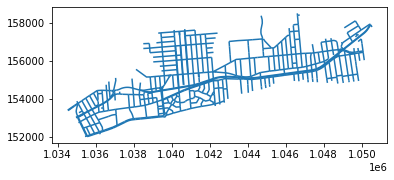

In [45]:
# sanity check plot
streets_clipped.plot()

## Snap Points to Streets

Methodology: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

The code below is from Brendan's awesome post.

In [46]:
# offset by 80 ft.
offset = 80
bbox = arverne_edgemere_gdf.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

tmp.head()

,pt_idx,line_i
0,8382,163.0
1,8382,165.0
2,8382,172.0
3,23171,162.0
4,23171,170.0


In [47]:
# join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True), 
    on="line_i"
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,8382,163.0,14454,BCH 69 ST,69,BCH 69 ST,1,Street,50.0,13,13,4,250.440212,"LINESTRING (1040166.129 157046.927, 1040147.64..."
1,8382,165.0,14452,DE COSTA AVE,DE COSTA,DE COSTA AVE,1,Street,32.0,13,13,4,693.197810,"LINESTRING (1040147.641 157296.684, 1039456.55..."
2,8382,172.0,14453,BCH 69 ST,69,BCH 69 ST,1,Street,50.0,13,13,4,244.881365,"LINESTRING (1040147.641 157296.684, 1040135.23..."
3,23171,162.0,104183,BCH 64 ST,64,BCH 64 ST,1,Street,30.0,13,13,4,494.620063,"LINESTRING (1041547.046 156907.594, 1041508.79..."
4,23171,170.0,80839,DE COSTA AVE,DE COSTA,DE COSTA AVE,1,Street,24.0,13,13,4,262.490798,"LINESTRING (1041508.798 157400.733, 1041247.05..."


In [48]:
# join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    arverne_edgemere_gdf.geometry.rename("point"), 
    on="pt_idx"
)

# convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp, 
    geometry="geometry", 
    crs=arverne_edgemere_gdf.crs
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,8382,163.0,14454,BCH 69 ST,69,BCH 69 ST,1,Street,50.0,13,13,4,250.440212,"LINESTRING (1040166.129 157046.927, 1040147.64...",POINT (1040148.000 157296.000)
1,8382,165.0,14452,DE COSTA AVE,DE COSTA,DE COSTA AVE,1,Street,32.0,13,13,4,693.197810,"LINESTRING (1040147.641 157296.684, 1039456.55...",POINT (1040148.000 157296.000)
2,8382,172.0,14453,BCH 69 ST,69,BCH 69 ST,1,Street,50.0,13,13,4,244.881365,"LINESTRING (1040147.641 157296.684, 1040135.23...",POINT (1040148.000 157296.000)
3,23171,162.0,104183,BCH 64 ST,64,BCH 64 ST,1,Street,30.0,13,13,4,494.620063,"LINESTRING (1041547.046 156907.594, 1041508.79...",POINT (1041513.000 157311.000)
4,23171,170.0,80839,DE COSTA AVE,DE COSTA,DE COSTA AVE,1,Street,24.0,13,13,4,262.490798,"LINESTRING (1041508.798 157400.733, 1041247.05...",POINT (1041513.000 157311.000)


In [49]:
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# discard any lines that are greater than tolerance from points
# sort on ascending snap distance, so that closest goes to top
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
1057,8444,181.0,168597,BCH 38 ST,38,BCH 38 ST,1,Street,32.0,13,13,4,130.294393,"LINESTRING (1048048.494 155857.248, 1048025.90...",POINT (1048026.000 155985.000),0.008927
1804,18044,262.0,197523,BCH 88 ST,88,BCH 88 ST,1,Street,30.0,13,13,4,50.091305,"LINESTRING (1036149.133 153656.343, 1036144.96...",POINT (1036145.000 153706.000),0.011066
1139,24202,466.0,104191,BCH 63 ST,63,BCH 63 ST,1,Street,30.0,13,13,4,395.083951,"LINESTRING (1041962.214 155024.238, 1041926.94...",POINT (1041927.000 155417.000),0.011800
611,6746,202.0,14316,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,32.0,13,13,4,248.362836,"LINESTRING (1049367.344 156350.038, 1049121.55...",POINT (1049367.000 156350.000),0.011995
2015,20410,830.0,14055,ROCKAWAY BEACH BLVD,ROCKAWAY BEACH,ROCKAWAY BEACH BLVD,1,Street,60.0,13,13,4,243.362356,"LINESTRING (1036175.788 153314.985, 1035951.77...",POINT (1035952.000 153220.000),0.017190


In [50]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()
closest = gpd.GeoDataFrame(closest, geometry="geometry")

# position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
5      POINT (1037023.858 154813.688)
6      POINT (1046656.040 155350.004)
28     POINT (1040075.192 156788.580)
33     POINT (1037023.858 154813.688)
135    POINT (1041879.776 156929.268)
dtype: geometry

In [51]:
# create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
5,432.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
6,324.0,180192,BCH 44 ST,44,BCH 44 ST,1,Street,30.0,13,13,4,411.513556,POINT (1046656.040 155350.004),POINT (1046656.000 155350.000),0.040469
28,144.0,14103,ALMEDA AVE,ALMEDA,ALMEDA AVE,1,Street,32.0,13,13,4,699.628862,POINT (1040075.192 156788.580),POINT (1040075.000 156791.000),2.427670
33,432.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
135,154.0,180494,ALMEDA AVE,ALMEDA,ALMEDA AVE,1,Street,30.0,13,13,4,410.828109,POINT (1041879.776 156929.268),POINT (1041880.000 156926.000),3.275961


In [52]:
# join back to the original points:
updated_points = (
    arverne_edgemere_gdf
    .drop(columns=["geometry"])
    .join(snapped)
    .dropna(subset=["geometry"])
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
8382,36474856,2017-06-18T17:44:00.000,2017-06-20T12:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,NaN,NaN,...,1,Street,50.0,13,13,4,250.440212,POINT (1040147.693 157295.977),POINT (1040148.000 157296.000),0.307548
23171,18558693,2010-08-25T17:32:00.000,2010-08-26T10:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,643 BEACH 64 STREET,BEACH 64 STREET,...,1,Street,30.0,13,13,4,494.620063,POINT (1041515.741 157311.213),POINT (1041513.000 157311.000),2.749361
19352,23287828,2012-05-23T18:42:00.000,2012-05-24T05:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,643 BEACH 63 STREET,BEACH 63 STREET,...,1,Street,30.0,13,13,4,240.424545,POINT (1041773.306 157333.270),POINT (1041770.000 157333.000),3.317418
6608,38698384,2018-03-15T13:35:00.000,2018-03-15T15:13:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,66-20 DECOSTA AVENUE,DECOSTA AVENUE,...,1,Street,30.0,13,13,4,267.662260,POINT (1040903.206 157353.043),POINT (1040903.000 157356.000),2.963919
18571,23960973,2012-09-06T12:58:00.000,2012-09-07T09:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,NaN,NaN,...,1,Street,42.0,13,13,4,495.233323,POINT (1040981.823 157357.986),POINT (1040982.000 157358.000),0.177131


In [53]:
updated_points.loc[:, ['snap_dist']].describe()

,snap_dist
count,657.000000
mean,2.926543
std,4.213832
min,0.008927
25%,0.469492
50%,2.675442
75%,3.226610
max,62.831774


Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

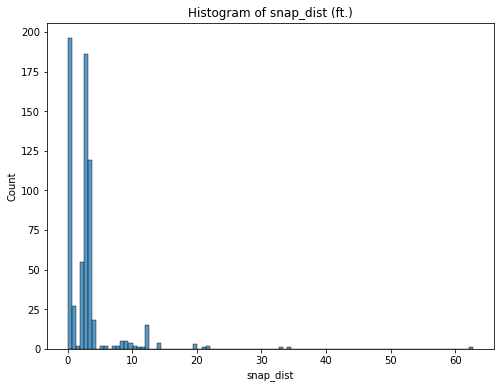

In [54]:
plt.figure(figsize=(8, 6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

<AxesSubplot:>

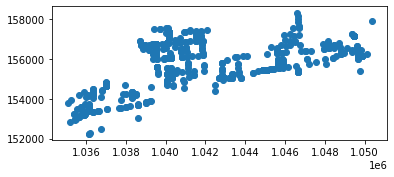

In [55]:
updated_points = gpd.GeoDataFrame(
    updated_points,
    geometry='point'
)

updated_points.plot()

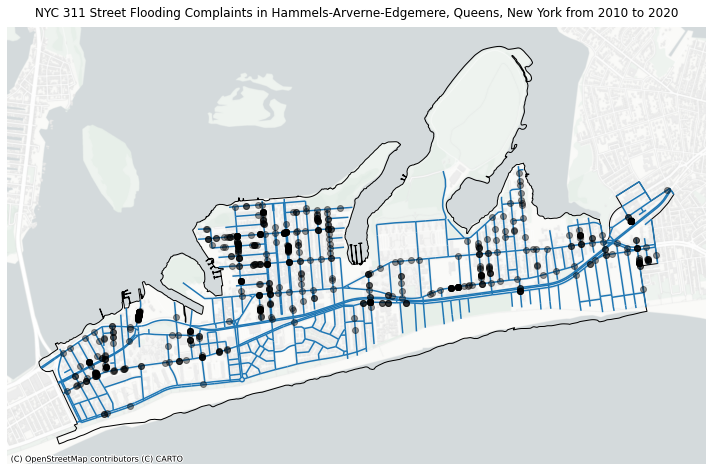

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

updated_points.plot(
    color='black',
    edgecolor='black',
    alpha=.4,
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, \
Queens, New York from 2010 to 2020'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()

In [57]:
# count of complaints by street
gdf_count = (
    updated_points
     .groupby(by='physicalid')['created_date']
     .count()
     .reset_index()
     .rename(columns={"created_date": "count"})
)

gdf_count.head()

,physicalid,count
0,101236,2
1,102480,1
2,104183,11
3,104184,4
4,104185,1


In [58]:
# buffer lines
streets_clipped = (
    streets_clipped
    .set_geometry('geometry')
    .assign(new_geom=lambda x: x.geometry.buffer(40, cap_style=2))
    .set_geometry('new_geom')
)

streets_clipped.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom
0,78354,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,270.314636,"LINESTRING (1040404.527 157564.752, 1040135.23...","POLYGON ((1040138.714 157501.402, 1040131.758 ..."
1,78352,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,286.212388,"LINESTRING (1040689.878 157586.944, 1040404.52...","POLYGON ((1040407.629 157524.872, 1040401.426 ..."
2,180499,BCH 69 ST,69,BCH 69 ST,1,Street,44.0,13,13,4,99.017756,"LINESTRING (1040135.236 157541.251, 1040128.58...","POLYGON ((1040088.677 157637.359, 1040168.496 ..."
3,78353,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,30.0,13,13,4,536.655816,"LINESTRING (1041224.822 157629.777, 1040689.87...","POLYGON ((1040693.070 157547.072, 1040686.685 ..."
4,14598,BCH 67 ST,67,BCH 67 ST,1,Street,30.0,13,13,4,98.405083,"LINESTRING (1040689.878 157586.944, 1040688.29...","POLYGON ((1040648.295 157684.691, 1040728.285 ..."


In [59]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['shape_leng'] = streets_with_count['geometry'].length
streets_with_count['count'] = streets_with_count['count'].fillna(0).astype(int)

streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    873 non-null    object  
 1   st_label      873 non-null    object  
 2   st_name       873 non-null    object  
 3   full_stree    873 non-null    object  
 4   rw_type       873 non-null    object  
 5   rw_type_name  873 non-null    object  
 6   st_width      873 non-null    object  
 7   frm_lvl_co    873 non-null    object  
 8   to_lvl_co     873 non-null    object  
 9   borocode      873 non-null    object  
 10  shape_leng    873 non-null    float64 
 11  geometry      873 non-null    geometry
 12  new_geom      873 non-null    geometry
 13  count         873 non-null    int64   
dtypes: float64(1), geometry(2), int64(1), object(10)
memory usage: 102.3+ KB


In [60]:
# normalize counts
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft
0,78354,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,270.314636,"LINESTRING (1040404.527 157564.752, 1040135.23...","POLYGON ((1040138.714 157501.402, 1040131.758 ...",1,0.369939
1,78352,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,286.212388,"LINESTRING (1040689.878 157586.944, 1040404.52...","POLYGON ((1040407.629 157524.872, 1040401.426 ...",0,0.000000
2,180499,BCH 69 ST,69,BCH 69 ST,1,Street,44.0,13,13,4,99.017756,"LINESTRING (1040135.236 157541.251, 1040128.58...","POLYGON ((1040088.677 157637.359, 1040168.496 ...",0,0.000000
3,78353,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,30.0,13,13,4,536.655816,"LINESTRING (1041224.822 157629.777, 1040689.87...","POLYGON ((1040693.070 157547.072, 1040686.685 ...",0,0.000000
4,14598,BCH 67 ST,67,BCH 67 ST,1,Street,30.0,13,13,4,98.405083,"LINESTRING (1040689.878 157586.944, 1040688.29...","POLYGON ((1040648.295 157684.691, 1040728.285 ...",0,0.000000


In [61]:
streets_with_count.loc[:, ['count', 'count_per_100ft']].describe()

,count,count_per_100ft
count,873.000000,873.000000
mean,0.752577,0.394024
std,2.604371,1.995980
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,46.000000,32.548808


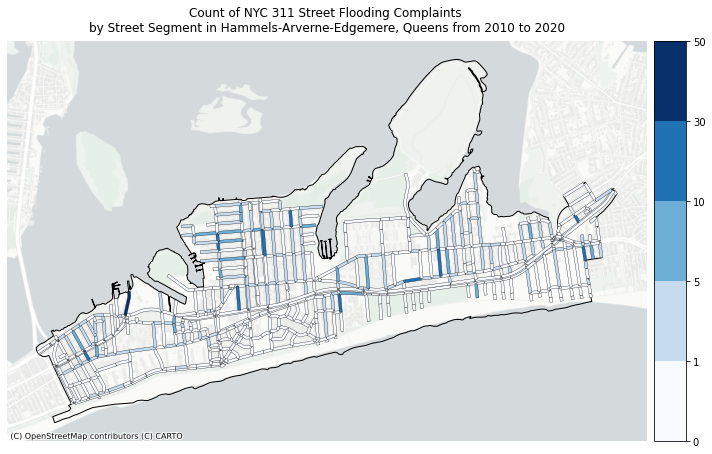

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 5, 10, 30, 50], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax, 
    norm=norm,
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'Count of NYC 311 Street Flooding Complaints \n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
ax.set_title(label=label, fontsize=12, pad=10)

ax.axis('off')
plt.tight_layout()

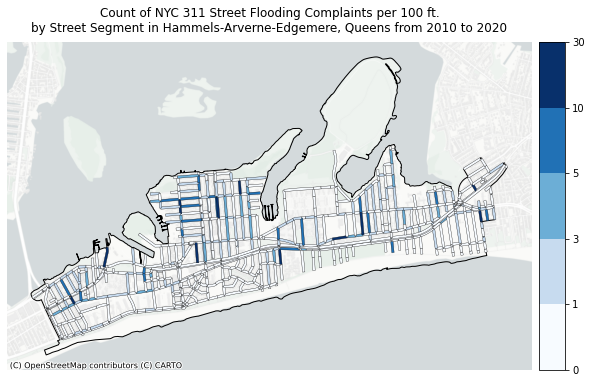

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# get max of array and place as top bounds
norm = mpl.colors.BoundaryNorm([0, 1, 3, 5, 10, 30], cmap.N)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax, 
    norm=norm,
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(arverne_edgemere_shape
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
ax.set_title(label=label, fontsize=12, pad=10)

ax.axis('off')
plt.savefig('figures/arverne.png', dpi=250, bbox_inches='tight')

In [64]:
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft,street_and_id
0,78354,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,270.314636,"LINESTRING (1040404.527 157564.752, 1040135.23...","POLYGON ((1040138.714 157501.402, 1040131.758 ...",1,0.369939,"BAYFIELD AVE, id:78354"
1,78352,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,25.0,13,13,4,286.212388,"LINESTRING (1040689.878 157586.944, 1040404.52...","POLYGON ((1040407.629 157524.872, 1040401.426 ...",0,0.000000,"BAYFIELD AVE, id:78352"
2,180499,BCH 69 ST,69,BCH 69 ST,1,Street,44.0,13,13,4,99.017756,"LINESTRING (1040135.236 157541.251, 1040128.58...","POLYGON ((1040088.677 157637.359, 1040168.496 ...",0,0.000000,"BCH 69 ST, id:180499"
3,78353,BAYFIELD AVE,BAYFIELD,BAYFIELD AVE,1,Street,30.0,13,13,4,536.655816,"LINESTRING (1041224.822 157629.777, 1040689.87...","POLYGON ((1040693.070 157547.072, 1040686.685 ...",0,0.000000,"BAYFIELD AVE, id:78353"
4,14598,BCH 67 ST,67,BCH 67 ST,1,Street,30.0,13,13,4,98.405083,"LINESTRING (1040689.878 157586.944, 1040688.29...","POLYGON ((1040648.295 157684.691, 1040728.285 ...",0,0.000000,"BCH 67 ST, id:14598"


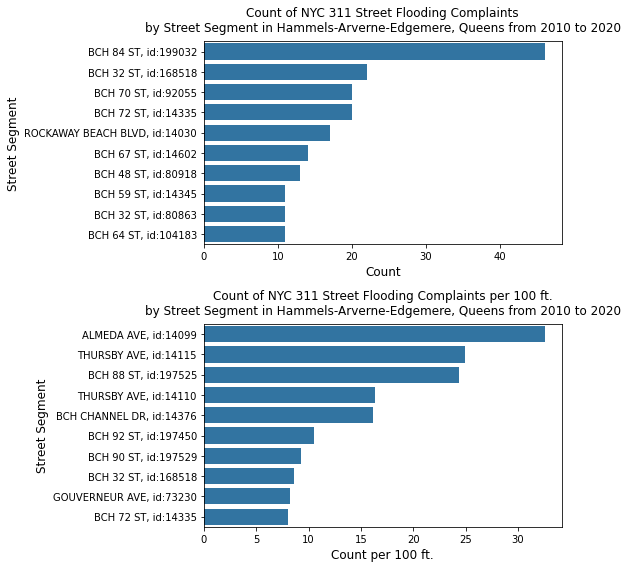

In [66]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 8))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints\n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
axs[0].set_title(label, fontsize=12, pad=10)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Street Segment', fontsize=12)

# second plot
data = streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in Hammels-Arverne-Edgemere, Queens from 2010 to 2020'
axs[1].set_title(label, fontsize=12, pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=12)
axs[1].set_ylabel('Street Segment', fontsize=12)

plt.tight_layout()